In [10]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Point
import geopandas as gpd
from cartopy.io import shapereader
import glob
import pandas as pd

xr.set_options(keep_attrs=True, display_expand_data=False)
np.set_printoptions(threshold=10, edgeitems=2)

In [47]:
# Load all of the January 2023 data (will give better coverage) and select number of days to plot, default set as 3
num_days = 3 
file_list = sorted(glob.glob('Data/01' + '/*.nc'))[:num_days]

# Initialize empty list to collect DataFrames
df_list = []

for f_name in file_list:
    ds = xr.open_dataset(f_name)

    # Extract variables (Methan xch4 is selected)
    lat = ds['latitude']
    lon = ds['longitude']
    xch4 = ds['xch4']

    # Mask invalid values
    valid = (xch4 > 0) & (~xch4.isnull())
    lat_valid = lat.where(valid, drop=True)
    lon_valid = lon.where(valid, drop=True)
    xch4_valid = xch4.where(valid, drop=True)



    # Create DataFrame
    df = pd.DataFrame({
        'lat': lat_valid.values,
        'lon': lon_valid.values,
        'xch4': xch4_valid.values
    }).dropna()

    df_list.append(df)

# Concatenate all DataFrames
all_data = pd.concat(df_list, ignore_index=True)

### Plot January 2023 Data with plot settings in 4K Resolution

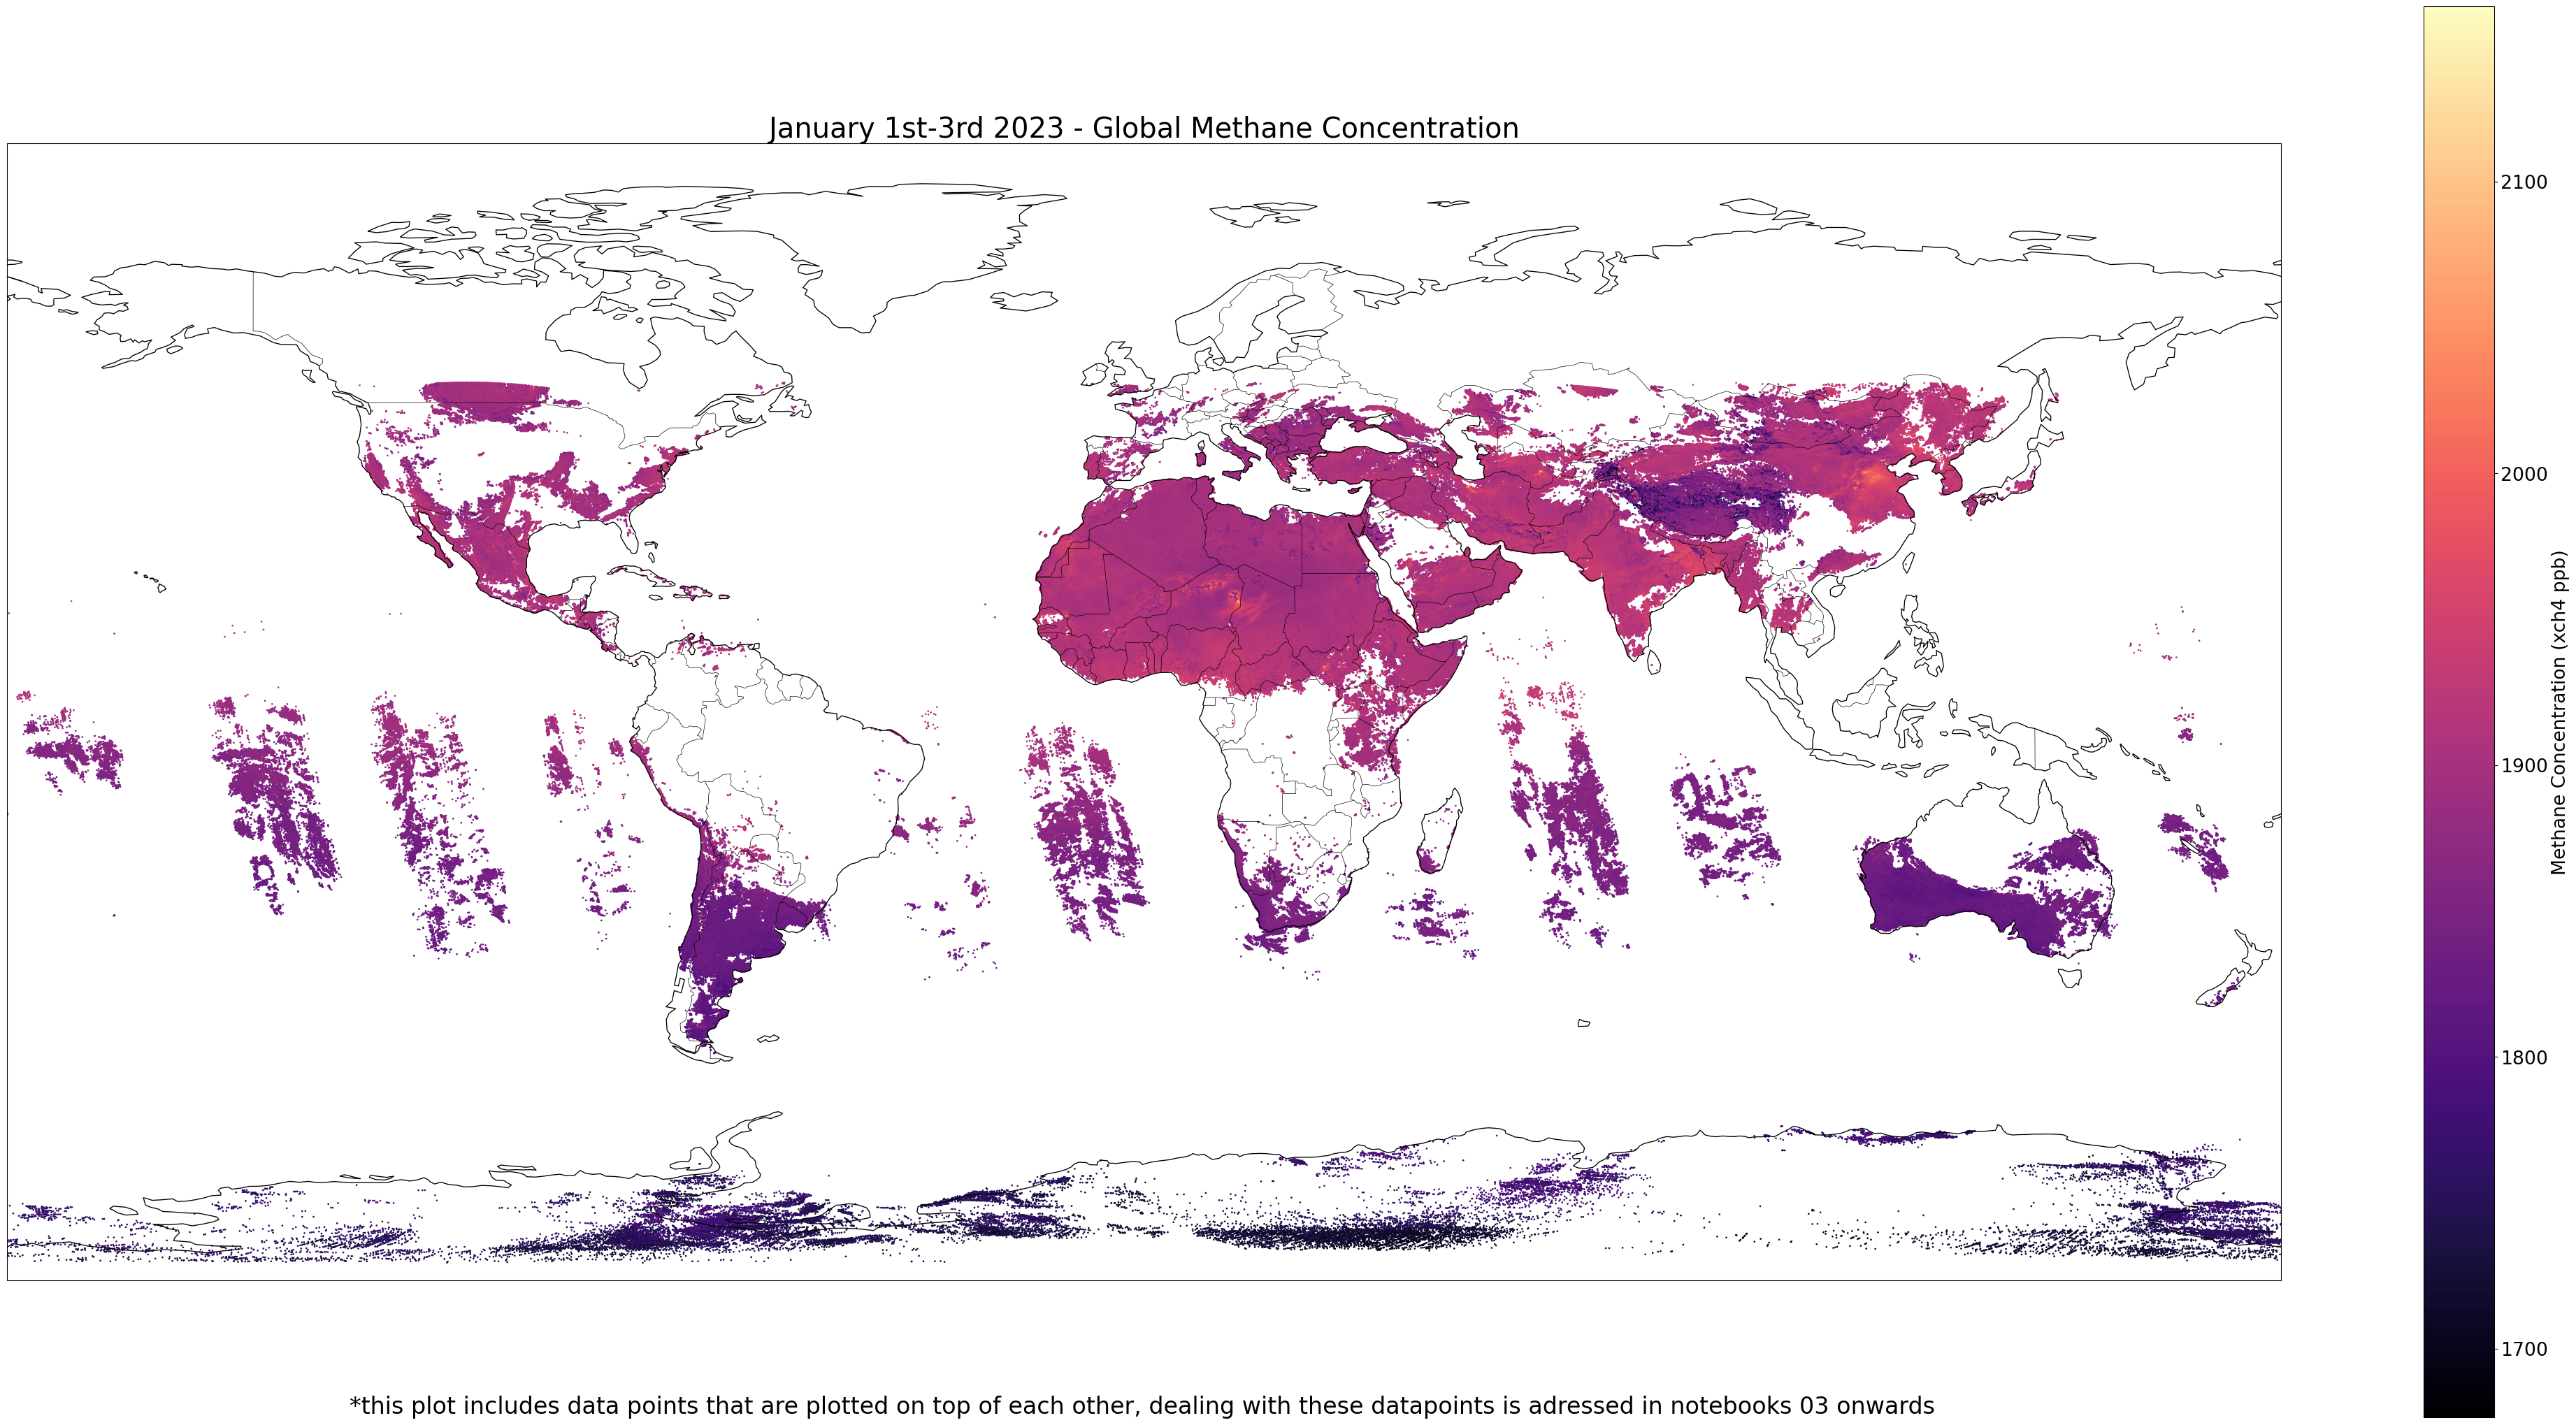

In [59]:
#4K Figure Resolution (we require these settings - as a user you can change as you please)
dpi = 96
width_in = 4096 / dpi
height_in = 2048 / dpi

# Create figure
fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)
ax = plt.axes(projection=ccrs.PlateCarree())

# Optional: add features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.set_global()

# Scatter plot
sc = ax.scatter( all_data['lon'], all_data['lat'], c=all_data['xch4'], cmap='magma', s=1, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, pad=0.05)
cbar.ax.tick_params(labelsize=20)  # Change tick label font size
cbar.set_label('Methane Concentration (xch4 ppb)', fontsize=20)

plt.title('January 1st-3rd 2023 - Global Methane Concentration' , size = 30, pad = 5)
plt.tight_layout()

# Add a caption below the figure
fig.text(0.4, 0.01, '*this plot includes data points that are plotted on top of each other, dealing with these datapoints is adressed in notebooks 03 onwards',
         ha='center', fontsize=25)
# Note that this figure has incomplete coverage of the earth as TROPOMI does not get complete coverage of the earth in a single day or even 3 days
# The default colour bar is also not very informative, we address this in notebook 03 onwards too
plt.show()

### Testing Colour Palettes for plotting

Here we test out colour schemes for the sea , land and data points with mock data. In the test plot data is not plotted on the sea. <br> 
Users can try out their own colour schemes with this code <br>

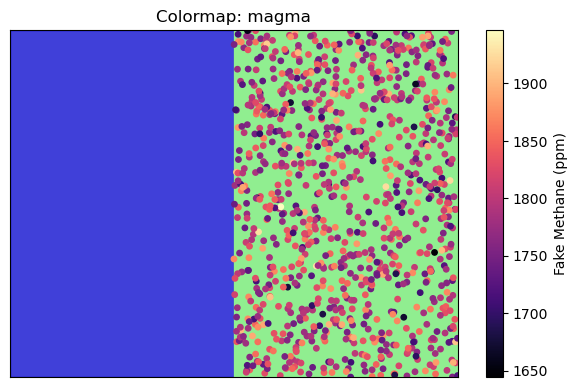

In [49]:
# ========== SETTINGS ==========
LAND_COLOR = "lightgreen" 
SEA_COLOR = SEA_COLOR = "mediumblue"  
CMAP_TO_TEST = "magma"  # Try 'plasma', 'inferno', 'cividis', etc.
N = 1000  # number of fake data points
# ==============================

# Generate fake points over land area (right half)
np.random.seed(0)
x = np.random.uniform(0, 1, N)          # Only right half (land)
y = np.random.uniform(0, 1, N)
fake_methane = np.random.normal(loc=1800, scale=50, size=N)

# Create plot
fig, ax = plt.subplots(figsize=(6, 4))

# Plot sea (left half rectangle)
ax.add_patch(plt.Rectangle((0, 0), 0.5, 1, color=SEA_COLOR, zorder=0, alpha = 0.75))

# Plot land (right half rectangle)
ax.add_patch(plt.Rectangle((0.5, 0), 0.5, 1, color=LAND_COLOR, zorder=0))

# Plot fake methane data only on land
sc = ax.scatter(x * 0.5 + 0.5, y, c=fake_methane, cmap=CMAP_TO_TEST, s=15, zorder=1)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Fake Methane (ppm)", fontsize=10)

# Final touches
ax.set_title(f"Colormap: {CMAP_TO_TEST}", fontsize=12)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

#### 4K Plot with Green Land Colour and Blue Sea Colour

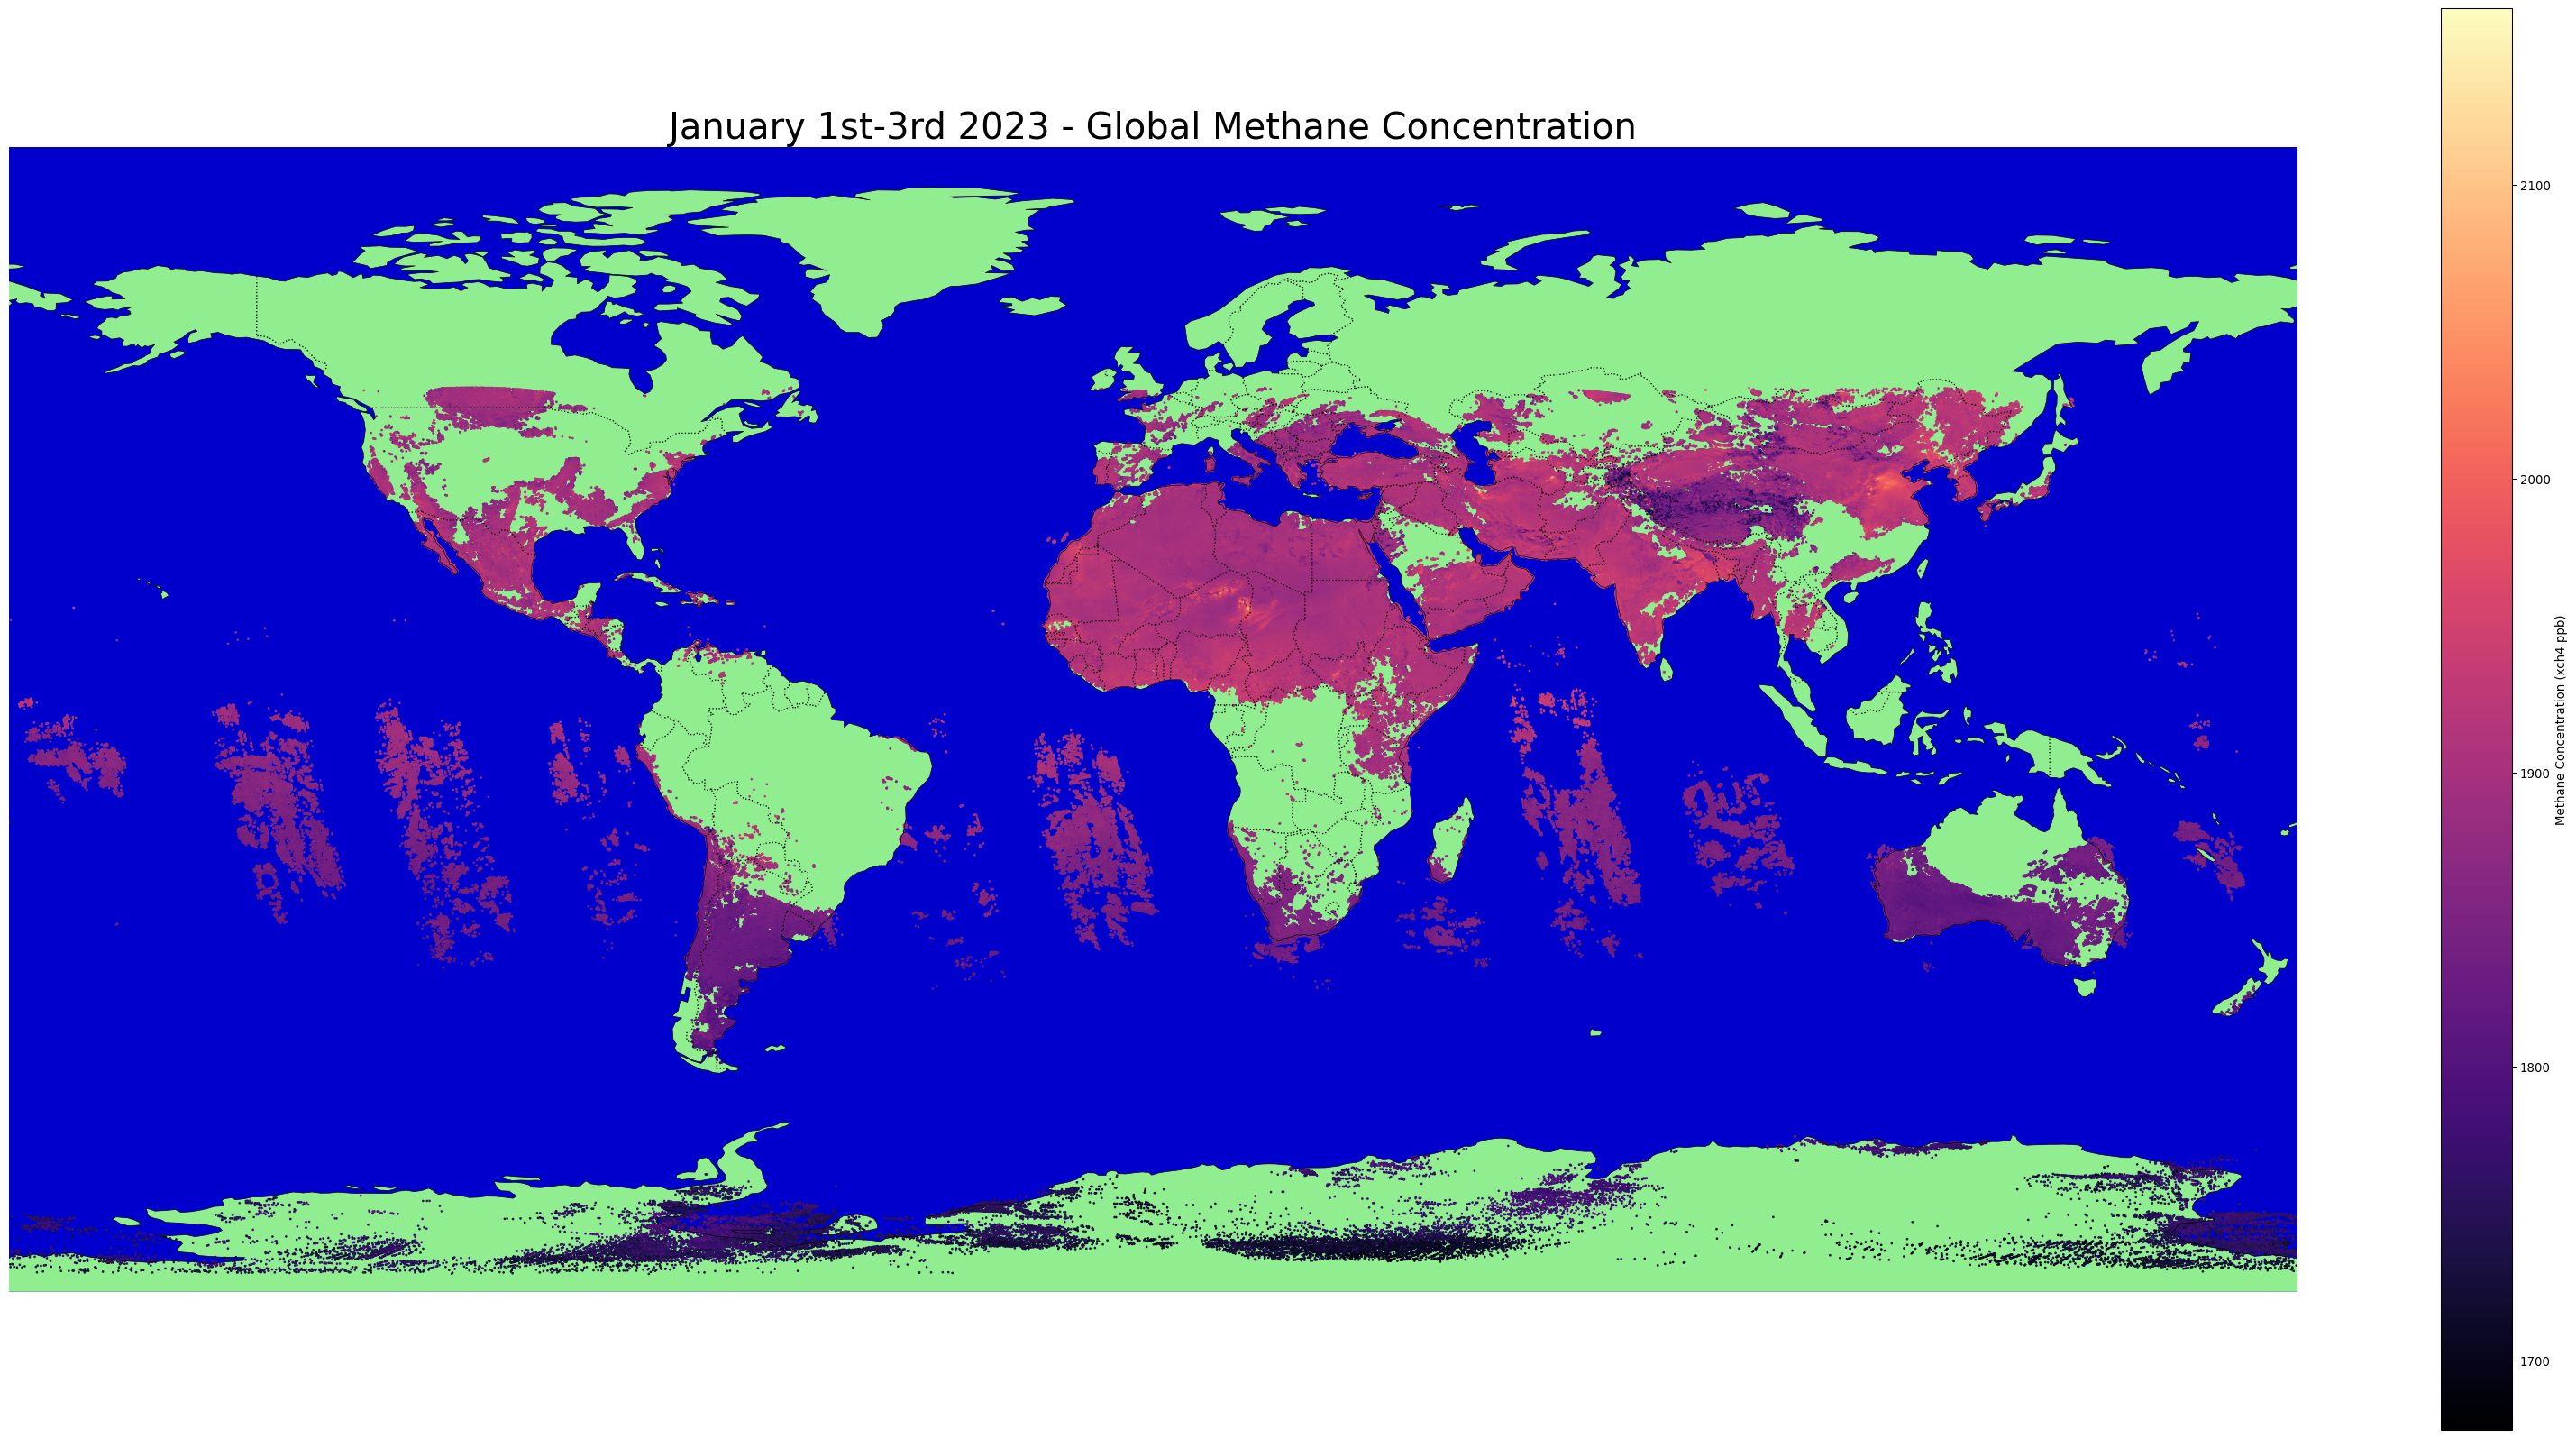

In [55]:
# Colours defined above

# Set DPI and figure size
dpi = 96
width_in = 4096 / dpi
height_in = 2048 / dpi

fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_facecolor(SEA_COLOR)  # Sea background color

# Add land as a white shape layer
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor=LAND_COLOR, edgecolor='none')

#__ Masking Start 

# # Load land polygons for masking
# land = gpd.read_file("shapefiles/ne_10m_admin_0_countries.shp")  # Adjust path if needed

# # Convert lon/lat to Point geometries
# points = gpd.GeoSeries([Point(xy) for xy in zip(lon, lat)], crs="EPSG:4326")

# # Keep only land points
# land_points = gpd.sjoin(gpd.GeoDataFrame(geometry=points), land, how="inner", predicate="within")

# # Extract only land values
# valid_indices = land_points.index
# lon_land = np.array(lon)[valid_indices]
# lat_land = np.array(lat)[valid_indices]
# c_valid_land = np.array(c_valid)[valid_indices]

# ___ Masking End 

# # Scatter plot for land-only data
# sc = ax.scatter(
#     lon_land, lat_land, c=c_valid_land, s=1,
#     cmap="magma", transform=ccrs.PlateCarree()
# )

sc = ax.scatter( all_data['lon'], all_data['lat'], c=all_data['xch4'], cmap='magma', s=1, transform=ccrs.PlateCarree())

# Add colorbar
cbar = plt.colorbar(sc, pad=0.05)
cbar.ax.tick_params(labelsize=20)  # Change tick label font size
cbar.set_label('Methane Concentration (xch4 ppb)', fontsize=20)

plt.title('January 1st-3rd 2023 - Global Methane Concentration' , size = 30, pad = 10)


# Add borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor=BORDER_COLOR)
ax.coastlines(color=COASTLINE_COLOR, linewidth=0.5)

# Remove ticks and frame
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()

#### 4K Plot with Sea Masked and Green Land Colour / Blue Sea Colour

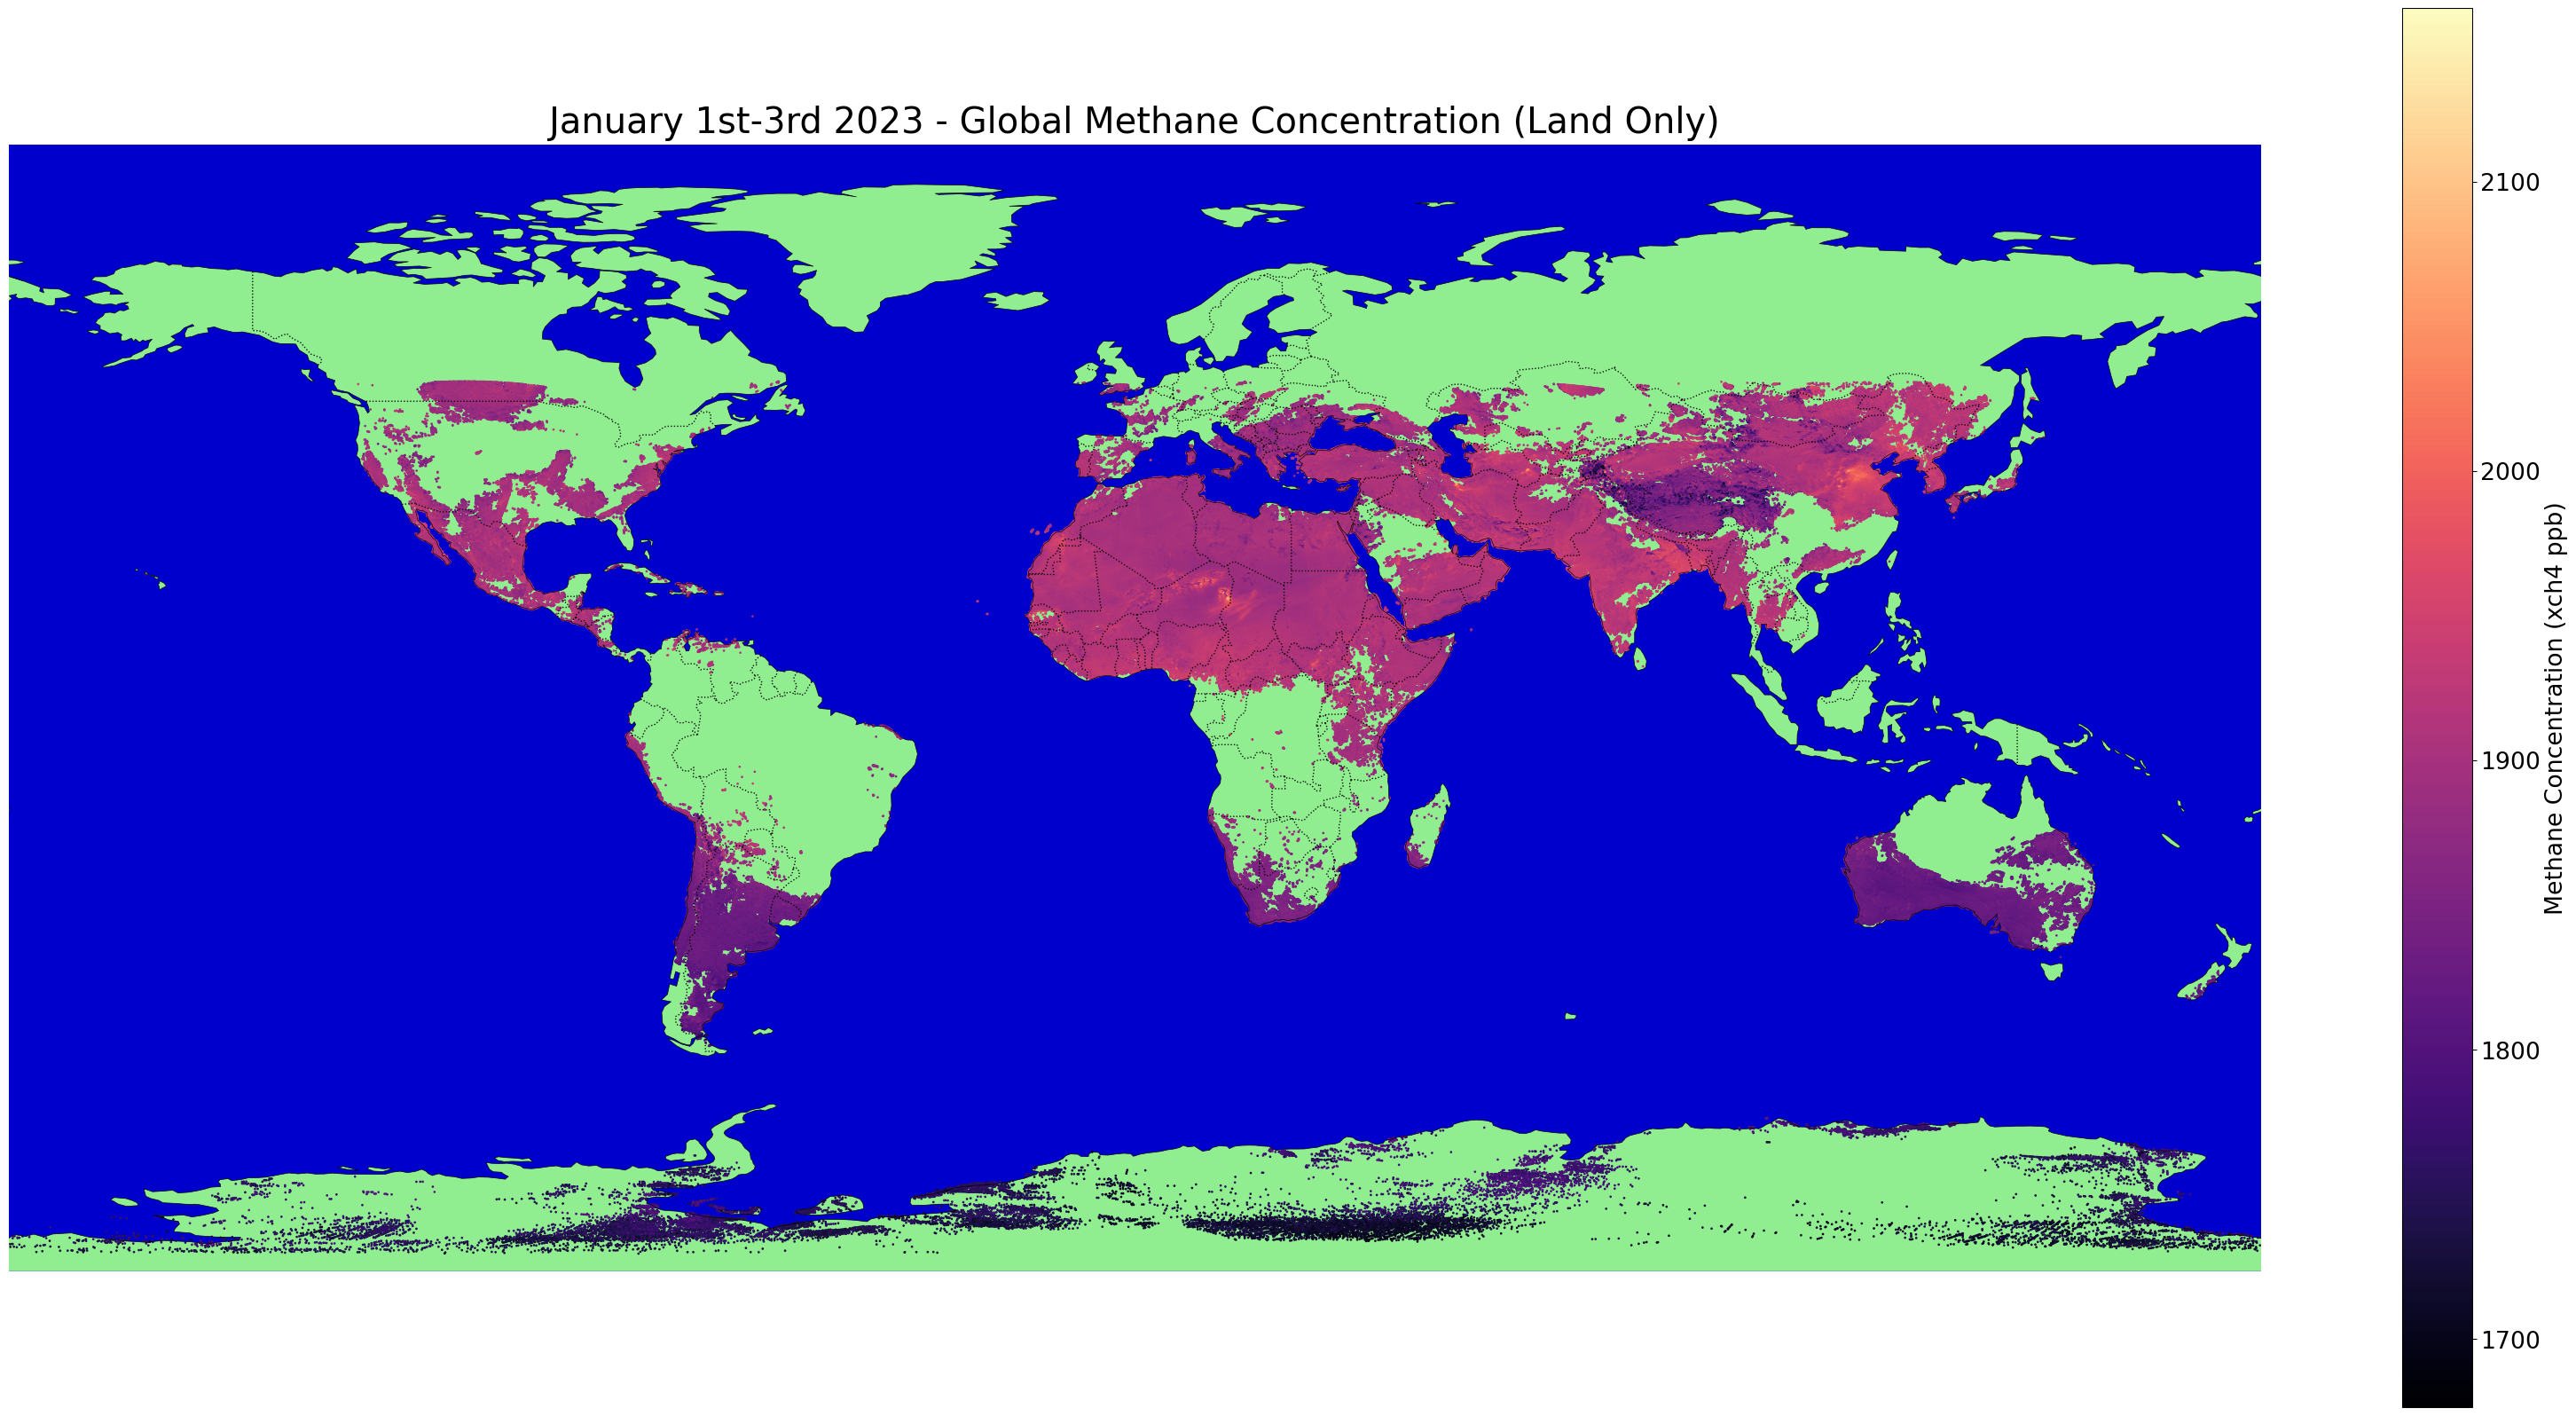

In [61]:
# Colours defined above

# Set DPI and figure size
dpi = 96
width_in = 4096 / dpi
height_in = 2048 / dpi

fig = plt.figure(figsize=(width_in, height_in), dpi=dpi)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.set_facecolor(SEA_COLOR)  # Sea background color

# Add land as a white shape layer
ax.add_feature(cfeature.LAND.with_scale('110m'), facecolor=LAND_COLOR, edgecolor='none')

# Load land polygons for masking
land = gpd.read_file("shapefiles/ne_10m_admin_0_countries.shp")  # Adjust path if needed

# Define lon, lat and xch4 for masking and plotting code below

lon = all_data['lon']
lat = all_data['lat'] 
c_valid = all_data['xch4'] #this is the data to be plotted

# Convert lon/lat to Point geometries
points = gpd.GeoSeries([Point(xy) for xy in zip(lon, lat)], crs="EPSG:4326")

# Keep only land points
land_points = gpd.sjoin(gpd.GeoDataFrame(geometry=points), land, how="inner", predicate="within")

# Extract only land values
valid_indices = land_points.index
lon_land = np.array(lon)[valid_indices]
lat_land = np.array(lat)[valid_indices]
c_valid_land = np.array(c_valid)[valid_indices]

# Scatter plot for land-only data
sc = ax.scatter(
    lon_land, lat_land, c=c_valid_land, s=1,
    cmap="magma", transform=ccrs.PlateCarree()
)

# Add colorbar
cbar = plt.colorbar(sc, pad=0.05)
cbar.ax.tick_params(labelsize=20)  # Change tick label font size
cbar.set_label('Methane Concentration (xch4 ppb)', fontsize=20)

plt.title('January 1st-3rd 2023 - Global Methane Concentration (Land Only)' , size = 30, pad = 10)

# Add borders and coastlines
ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor=BORDER_COLOR)
ax.coastlines(color=COASTLINE_COLOR, linewidth=0.5)

# Remove ticks and frame
ax.set_xticks([])
ax.set_yticks([])
for spine in ax.spines.values():
    spine.set_visible(False)

plt.show()